# IQFT with QPIE

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex
from scipy.fft import fft2, ifft2
from skimage import io
from skimage.transform import resize
import h5py

from skimage import color

In [2]:
def qpie_circuit(im):
    
    n = int(np.log2(len(im)))

    vals = im.flatten()
    vals = vals/np.linalg.norm(vals) 

    qc = QuantumCircuit(2*n)

    qc.initialize(vals)

    return qc

In [3]:
n = 32 

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 7)
radius = 1 

for i in range(0, stars):
    index_i = np.random.randint(0, n-radius)
    index_j = np.random.randint(0, n-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

sky_image = sky_image.real.astype('float64')

print(sky_image.dtype)

float64


In [4]:
ft = np.fft.fft2(sky_image)
print(ft.dtype)

complex128


In [5]:
def decode_out(qc,norm,fourier=False,fourier_inverse=False,shots_mult=1):
    
    n = qc.num_qubits
    shots = shots_mult * 2**20 

    backend = Aer.get_backend('qasm_simulator')
    results = execute(qc, backend=backend, shots=shots, memory=True).result()
    answer = results.get_counts()

    outim = np.zeros((int(2**(n/2)), int(2**(n/2))))

    b = 0
    for i,j in np.ndindex(outim.shape):

        bit = format(b, '0' + str(n) + 'b')
        p_i = answer.get(bit,0)/shots
        
        if fourier:
            pix_val = np.sqrt(p_i) * norm * 2**(n/2)
        
        elif fourier_inverse:
            pix_val = np.sqrt(p_i) * norm / 2**(n/2)
        else:
            pix_val = np.sqrt(p_i) * norm
            
        outim[i,j] = (pix_val)

        b+=1
    
    return outim

In [6]:
def MSE(im1,im2):

    im = (im1-im2)**2
    s = np.sum(im.flatten())/(len(im1**2))
    return s

In [7]:
qc = qpie_circuit(ft)
qc.append(QFT(5,insert_barriers=True, inverse=True, name='IQFT'),[0,1,2,3,4])
qc.append(QFT(5,insert_barriers=True, inverse=True, name='IQFT'),[5,6,7,8,9])


qc.measure_all()

norm = (np.linalg.norm(ft.flatten()))
iqft = decode_out(qc,norm,fourier_inverse=True) 
print(iqft.dtype)

float64


In [8]:
MSE(sky_image, iqft)

1095.2738917861057

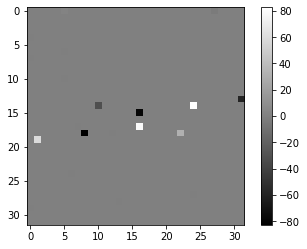

In [9]:
plt.imshow(sky_image-iqft, cmap='gray')
plt.colorbar()

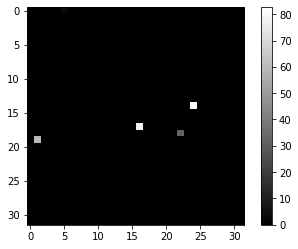

In [10]:
plt.imshow(sky_image, cmap='gray')
plt.colorbar()

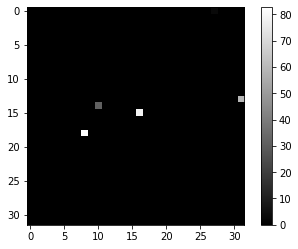

In [11]:
plt.imshow(iqft, cmap='gray')
plt.colorbar()